# Group Assignment 1 for course CIE4365

## Water Balance of the Wieringermeer Landfill
Group 8 @author: Yiman Liu      5456703
                 Yuwei Huang    5555566
                 Yukun Xie      5594448
                 Mingkai Wei

## Initialization of the code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import warnings
import time
import scipy.integrate as spint
%matplotlib inline
warnings.filterwarnings('ignore')      #inhibit warning

In [3]:
import pandas as pd
data1 = pd.read_excel('WieringermeerData_Meteo.xlsx', index_col = 0, parse_dates = [0])
data2 = pd.read_excel('WieringermeerData_LeachateProduction.xlsx', names = ['time','Leachate'], parse_dates = [0], index_col = 0)
data = pd.concat([data1, data2], axis = 1, join = 'outer')    #outer connect two excels, remain axis with nan value          
J, EV, T, L = np.array(data.iloc[:, :4]).T                    #get values by transpose

In [ ]:
# Definition of initial parameters
Ac = 28355              #m^2, surface area of waste body
Aw = 9100               #m^2, surface area of cover layer
beta0 = 0.8             #range 0-2.5
p = 0.4                 #Soil porosity
a = 0.2                 #10*(-1) - 10**4 [m/day]
bcl = 14                #dimensionless empirical parameter
bwb = 2                 #dimensionless empirical parameter
Sclmin = 0.5 * p * 1.5  #m, minimum storage in the cover layer
Swbmin = 0.5 * p * 12   #m, minimum storage in the waste body
Sclmax = 1.5 * p        #m, maximum storage in the cover layer 
Swbmax = 12 * p         #m, maximum storage in the waste body
Sevmin = 0.05
Sevmax = 0.5
Cf = 0.7                #crop factor
pcl = 0.6
pwb = 0.4

Y0 = np.array([0.27,0.5])   #initial value
tOut = np.linspace(0, len(L) - 1, len(L))  #time steps, use len()-1 to get values like 0, 1, 2... and avoid exceed the index in later functions 

In [5]:
# Definition of Rate Equation
def correction(Scl, Swb):
    Scl = ((Scl < Sclmin) * Sclmin + (Sclmin <= Scl <= Sclmax) * Scl + (Scl > Sclmax) * Sclmax)
    Swb = ((Swb < Swbmin) * Swbmin + (Swbmin <= Swb <= Swbmax) * Swb + (Swb > Swbmax) * Swbmax)
    return Scl, Swb
    
def create_lcl_lwb_beta(Scl, Swb):
    L_cl = a * ((Scl - Sclmin) / (Sclmax - Sclmin)) ** bcl
    L_wb = a * ((Swb - Swbmin) / (Swbmax -Swbmin)) ** bwb
    beta = beta0 * ((Scl - Sclmin) / (Sclmax - Sclmin))
    return L_cl, L_wb, beta

def Leachte(Scl, Swb):      #m^3/d
    L_cl, L_wb, beta = create_lcl_lwb_beta(Scl, Swb)
    return beta * L_cl * Ac + L_wb * Aw

def Leachte_nonarea(Scl, Swb):     #m/d
    L_cl, L_wb, beta = create_lcl_lwb_beta(Scl, Swb)
    return beta * L_cl + L_wb

def dYdt(t, Y):
    Y[0], Y[1] = correction(Y[0], Y[1]) 
    fred = ((Y[0] < Sevmin) * 0 + (Sevmin <= Y[0] <= Sevmax) * ((Y[0] - Sevmin) / (Sevmax - Sevmin)) + (Y[0] > Sevmax) * 1)
    lcl, lwb, beta = create_lcl_lwb_beta(Y[0], Y[1])
    et = EV[int(t)] * Cf * fred
    return np.array([J[int(t)] - lcl - et, (1 - beta) * lcl - lwb])

## Solution using built in solver (odeint)

Elapsed time is 9.414387226104736 seconds.


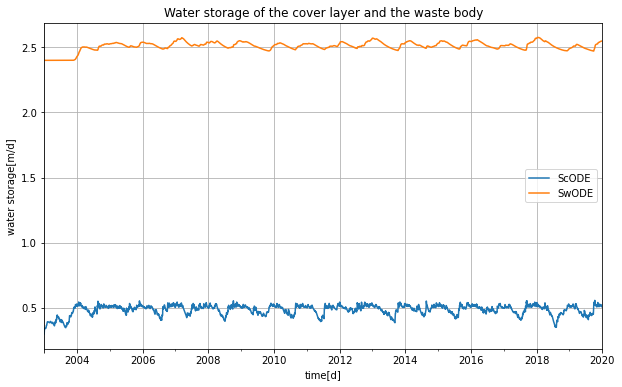

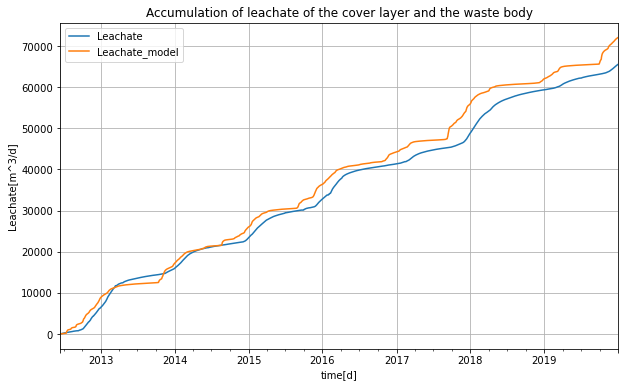

In [6]:
#Calculation of model
start = time.time()
t_span = [tOut[0], tOut[-1]]
YODE = spint.solve_ivp(dYdt, t_span, Y0, t_eval = tOut, vectorized = True, method = 'RK45', rtol = 1e-5)
data['ScODE'] = YODE.y[0, :]            #create dataframes directly
data['SwODE'] = YODE.y[1, :]
print (f"Elapsed time is {time.time() - start} seconds.")            #get running time

#global plot of Model
data.ScODE.plot(figsize = [10, 6], xlabel = 'time[d]', ylabel = 'water storage[m/d]', title = 'Water storage of the cover layer and the waste body', grid = True, legend = True)
data.SwODE.plot(grid = True, legend = True)

#local plot of Model & experiment
data_nonan = data.dropna(axis = 0, how = 'any')          #delete all axis with nan values
correction = np.vectorize(correction)
ScODE, SwODE = correction(data_nonan.ScODE, data_nonan.SwODE) 
data_nonan['Leachate_model'] = np.cumsum(Leachte(ScODE, SwODE))
plt.figure(figsize=[10,6])
data_nonan.Leachate.plot(xlabel = 'time[d]', ylabel = 'Leachate[m^3/d]', title = 'Accumulation of leachate of the cover layer and the waste body', grid = True, legend = True)
data_nonan.Leachate_model.plot(grid = True, legend = True);

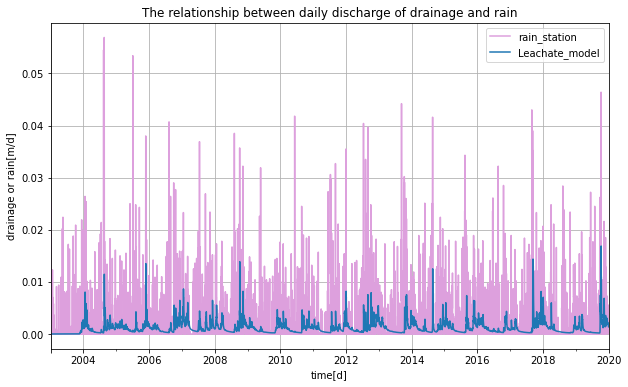

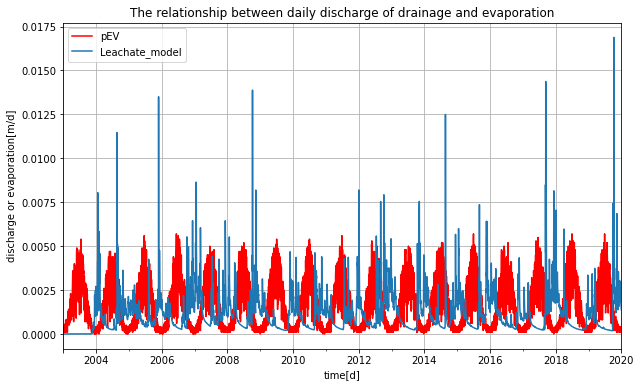

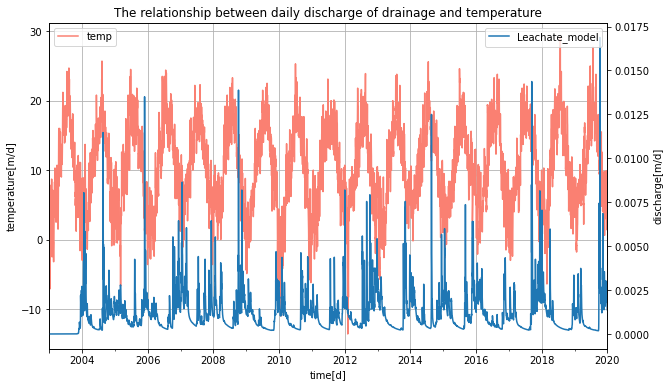

In [14]:
ScODE, SwODE = correction(data.ScODE, data.SwODE)
data['Leachate_model'] = Leachte_nonarea(ScODE, SwODE)        #create new colum with no area calculation

#rain and Leachate
data.rain_station.plot(figsize = [10, 6], xlabel = 'time[d]', ylabel = 'drainage or rain[m/d]', color='plum', title = 'The relationship between daily discharge of drainage and rain', grid = True, legend = True)
data.Leachate_model.plot(grid = True, legend = True)

#evaporation and Leachate
plt.figure(figsize = [10, 6])
data.pEV.plot(xlabel = 'time[d]', ylabel = 'discharge or evaporation[m/d]', color='r', title = 'The relationship between daily discharge of drainage and evaporation', grid = True, legend = True)
data.Leachate_model.plot(grid = True, legend = True)

#Temperature and Leachate
fig, ax = plt.subplots(figsize = [10, 6])
ax2 = ax.twinx()             #create mirror y-axis
data.temp.plot(ax = ax, xlabel = 'time[d]', ylabel = 'temperature[m/d]', color='salmon', title = 'The relationship between daily discharge of drainage and temperature', grid = True, legend = True)
#plt.legend(loc='lower left')
data.Leachate_model.plot(ax = ax2,  ylabel = 'discharge[m/d]', legend = True)
plt.legend(loc = 'upper right');